In [1]:
from numpy import loadtxt 
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd 

In [4]:
# loaddataset 
dataset = pd.read_csv('diabetes.csv') 

In [5]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
X = dataset.drop('Outcome', axis=1).values 
y = dataset.Outcome.values 

In [7]:
# set seed and split to train and test datasets 
seed = 7 
test_size = 0.33 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)

In [8]:
# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test 
predictions = model.predict(X_test)

In [9]:
# evaluate the models 
accuracy = accuracy_score(y_test, predictions) 


In [10]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.02%


[0.08907105 0.23959664 0.08799459 0.09824965 0.09801766 0.15170808
 0.09959181 0.13577053]


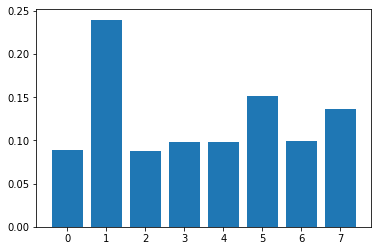

In [11]:
from matplotlib import pyplot

# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

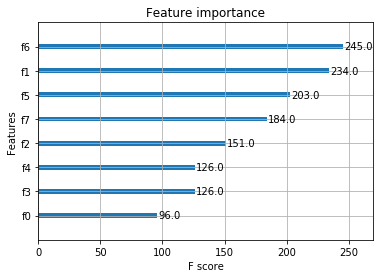

In [12]:
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
pyplot.show()

In [20]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort

accuracy_value = [] 
threshold_value = [] 
thresholds = sort(model.feature_importances_)
for thresh in thresholds: 
    # select features using threshold 
    selection = SelectFromModel(model, threshold = thresh, prefit=True) 
    select_X_train = selection.transform(X_train) 

    # train model 
    selection_model = XGBClassifier() 
    selection_model.fit(select_X_train, y_train) 

    #eval model 
    select_X_test = selection.transform(X_test) 
    predictions = selection_model.predict(select_X_test) 
    accuracy = accuracy_score(y_test, predictions) 
    threshold_value.append(select_X_train.shape[1]) 
    accuracy_value.append(accuracy)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1],accuracy*100.0))


Thresh=0.088, n=8, Accuracy: 74.02%
Thresh=0.089, n=7, Accuracy: 71.65%
Thresh=0.098, n=6, Accuracy: 71.26%
Thresh=0.098, n=5, Accuracy: 74.41%
Thresh=0.100, n=4, Accuracy: 74.80%
Thresh=0.136, n=3, Accuracy: 71.26%
Thresh=0.152, n=2, Accuracy: 71.26%
Thresh=0.240, n=1, Accuracy: 67.32%


In [23]:
import matplotlib.pyplot as plt

def plot_threshold_vs_accuracy(threshold_values, accuracy_values):
    plt.plot(threshold_values, accuracy_values, marker='o', linestyle='-')
    plt.xlabel('Features')
    plt.ylabel('Accuracy')
    plt.title('Threshold vs. Accuracy')
    plt.grid(True)
    plt.show()

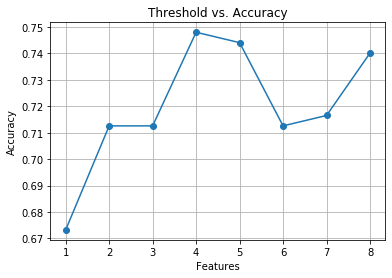

In [24]:
# Plot the threshold versus accuracy
plot_threshold_vs_accuracy(threshold_value, accuracy_value)

In [26]:
# early stopping with xgboost 
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

[0]	validation_0-error:0.13619	validation_0-logloss:0.55257	validation_1-error:0.28346	validation_1-logloss:0.60491
[1]	validation_0-error:0.10895	validation_0-logloss:0.46754	validation_1-error:0.25984	validation_1-logloss:0.55934
[2]	validation_0-error:0.10506	validation_0-logloss:0.40734	validation_1-error:0.25591	validation_1-logloss:0.53068
[3]	validation_0-error:0.09144	validation_0-logloss:0.36480	validation_1-error:0.24803	validation_1-logloss:0.51795
[4]	validation_0-error:0.08560	validation_0-logloss:0.33012	validation_1-error:0.24409	validation_1-logloss:0.51153
[5]	validation_0-error:0.07782	validation_0-logloss:0.29868	validation_1-error:0.24803	validation_1-logloss:0.50934
[6]	validation_0-error:0.06809	validation_0-logloss:0.27852	validation_1-error:0.25591	validation_1-logloss:0.50818
[7]	validation_0-error:0.06615	validation_0-logloss:0.26182	validation_1-error:0.24803	validation_1-logloss:0.51097
[8]	validation_0-error:0.06226	validation_0-logloss:0.24578	validation_1

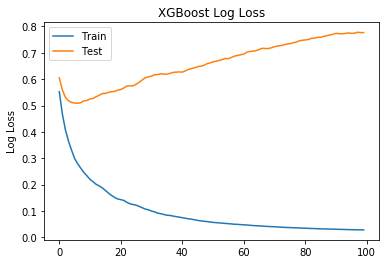

In [27]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

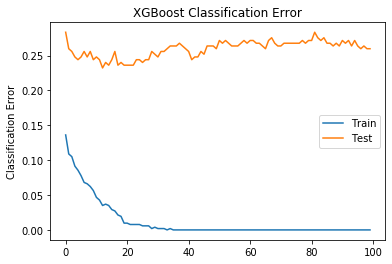

In [28]:
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [29]:
# fit model on training data and add early stopping to 10th epoch 
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss",eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-logloss:0.55257	validation_1-logloss:0.60491
[1]	validation_0-logloss:0.46754	validation_1-logloss:0.55934
[2]	validation_0-logloss:0.40734	validation_1-logloss:0.53068
[3]	validation_0-logloss:0.36480	validation_1-logloss:0.51795
[4]	validation_0-logloss:0.33012	validation_1-logloss:0.51153
[5]	validation_0-logloss:0.29868	validation_1-logloss:0.50934
[6]	validation_0-logloss:0.27852	validation_1-logloss:0.50818
[7]	validation_0-logloss:0.26182	validation_1-logloss:0.51097
[8]	validation_0-logloss:0.24578	validation_1-logloss:0.51760
[9]	validation_0-logloss:0.23298	validation_1-logloss:0.51912
[10]	validation_0-logloss:0.21955	validation_1-logloss:0.52503
[11]	validation_0-logloss:0.21051	validation_1-logloss:0.52697
[12]	validation_0-logloss:0.20083	validation_1-logloss:0.53335
[13]	validation_0-logloss:0.19466	validation_1-logloss:0.53905
[14]	validation_0-logloss:0.18725	validation_1-logloss:0.54545
[15]	validation_0-logloss:0.17765	validation_1-logloss:0.54613
[1